## NCAAM March ML Mania 

In [30]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.linear_model import LogisticRegression, LinearRegression

os.chdir("../../data/men")

### Data

- [Provided Data](https://www.kaggle.com/c/ncaam-march-mania-2021/data): 20 provided files including basic team info, box scores, and rankings
- [KenPom data](https://kenpom.com/): Pre-tournament efficiency from KenPom
   - Possession, player, and lineup level data is available, but not used.
   - Possession-level efficiency metrics: 
      - `AdjDE`: Expected points allowed per 100 possessions, adjusted for opponent strength and location.
      - `AdjDE`: Expected points allowed per 100 possessions, adjusted for opponent strength and location.
   - Note: Adjusted Efficiency Margin (`AdjEM`) is a linear combination of `AdjDE` and `AdjOE` (`AdjOE`-`AdjDE`), so we should not include all 3 in our model.

In [2]:
## Provided
teams_df            = pd.read_csv("MTeams.csv")
team_spellings_1_df = pd.read_csv("MTeamSpellings.csv")
team_spellings_2_df = pd.read_csv("MTeamSpellings_2.csv")
team_spellings_df   = pd.concat([team_spellings_1_df, team_spellings_2_df])
tourney_results_df  = pd.read_csv("MNCAATourneyCompactResults.csv")
sample_submission   = pd.read_csv("MSampleSubmissionStage1.csv")

## Kenpom
kenpom_df          = pd.read_csv("kenpom/pre-tourney-eff/kp-pre-tourney-2002-19-combined.csv")
kenpom_df['TeamName'] = kenpom_df['TeamName'].apply(lambda x: x.lower())
kenpom_df = kenpom_df.merge(team_spellings_df, left_on = 'TeamName', right_on = 'TeamNameSpelling')

Training data criteria:
  - In the past, I've only used past tournament games because they're most comparable in terms of being at a neutral-site and between teams of a certain quality.  
  - I'm open to using regular season data too.  However, KenPom data is only available at the end of the regular season (pre-tournament) and post-tournament, so it would be kind of cheating to use that to predict past games it was calculated from.

In [3]:
### Create a training dataset
tourney_results_df['Team1'] = tourney_results_df.apply(lambda x: x['WTeamID'] if x['WTeamID'] < x['LTeamID']
                                                 else x['LTeamID'], axis = 1)
tourney_results_df['Team2'] = tourney_results_df.apply(lambda x: x['WTeamID'] if x['WTeamID'] > x['LTeamID']
                                                 else x['LTeamID'], axis = 1)
## Targets
tourney_results_df['win']   = tourney_results_df.apply(lambda x: 1 if x['Team1'] == x['WTeamID']
                                                 else 0, axis = 1)
tourney_results_df['spread'] = tourney_results_df.apply(lambda x: x['WScore'] - x['LScore'] if x['Team1'] == x['WTeamID']
                                                 else x['LScore'] - x['WScore'], axis = 1)

### Merge the team names 
tourney_results_df = tourney_results_df.merge(teams_df, left_on='Team1', right_on='TeamID', suffixes = ('', '_1'))
tourney_results_df = tourney_results_df.merge(teams_df, left_on='Team2', right_on='TeamID', suffixes = ('', '_2'))

### Merge KP Data by Team Name and Season and subtract Team1 - Team2 for 1st variable
## For Team 1
kenpom_df.columns = [c + '_1' if c[len(c)-2:] not in ['_1', '_2'] else c[:-2] + '_1' for c in kenpom_df.columns]
tourney_results_df = tourney_results_df.merge(kenpom_df, left_on = ['Team1', 'Season'],
                                              right_on = ['TeamID_1', 'Season_1'])
## For Team 2
kenpom_df.columns = [c[:-2] + '_2' for c in kenpom_df.columns]
tourney_results_df = tourney_results_df.merge(kenpom_df, left_on = ['Team2', 'Season'],
                                              right_on = ['TeamID_2', 'Season_2'])

## Take differences between team1 and team2 for various stats
tourney_results_df['diff_AdjEM'] = tourney_results_df['AdjEM_1'] - tourney_results_df['AdjEM_2']
tourney_results_df['diff_AdjOE'] = tourney_results_df['AdjOE_1'] - tourney_results_df['AdjOE_2']
tourney_results_df['diff_AdjDE'] = tourney_results_df['AdjDE_1'] - tourney_results_df['AdjDE_2']
tourney_results_df['diff_AdjTempo'] = tourney_results_df['AdjEM_1'] - tourney_results_df['AdjEM_2']


### Viz

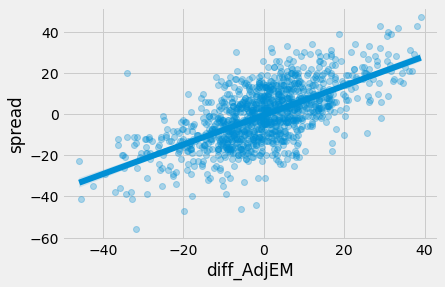

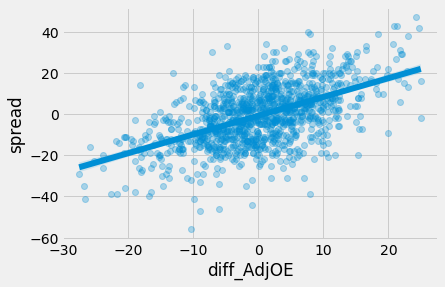

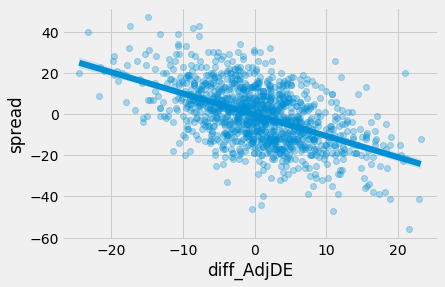

In [4]:
### Plot relationships between spread and differenced variables
## Effiency margin
sns.regplot(data = tourney_results_df, x = 'diff_AdjEM', y = 'spread', scatter_kws={'alpha':0.3})
plt.show()

## Offensive efficiency
sns.regplot(data = tourney_results_df, x = 'diff_AdjOE', y = 'spread', scatter_kws={'alpha':0.3})
plt.show()

## Defensive efficiency
sns.regplot(data = tourney_results_df, x = 'diff_AdjDE', y = 'spread', scatter_kws={'alpha':0.3})
plt.show()

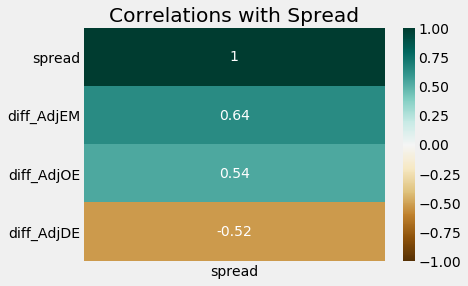

In [5]:
correlations = (tourney_results_df[['spread', 'diff_AdjOE', 'diff_AdjDE', 'diff_AdjEM']]
                 .corr()[['spread']].sort_values(by='spread', ascending=False))

heatmap = sns.heatmap(correlations, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlations with Spread');

### Model

For stage 1, we're evaluating our model against the 2015-2019 tournaments.  We can choose to simply train on 2002-2015 if want to make it simple.

In [9]:
train_df = tourney_results_df[tourney_results_df['Season'] < 2015].copy()
test_df  = tourney_results_df[tourney_results_df['Season'] >= 2015].copy()

### Binary outcome

Starting with logistic regression

In [10]:
X = train_df['diff_AdjEM'].values.reshape(-1, 1)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='ovr').fit(X, train_df['win'])

probs = clf.predict_proba(X) ### first in the array is probability of 0 (loss), second is prob of win (1)

train_df['fitted_probabilities'] = probs[:,1]

In [17]:
print(f"AdjEM Odds Ratio: {np.round(np.exp(clf.coef_[0])[0], 3)}")

AdjEM Odds Ratio: 1.131


Interpretation: For every 1 point increase in a team's AdjEM margin over than their opponents, the odds that the team wins are 1.13 times greater as the odds that the team loses.

### Spread

Starting with simple linear regression.

In [22]:
reg = LinearRegression().fit(X, train_df['spread'])

print(f"Coefficients {reg.coef_}")
print(f"R-Squared {np.round(reg.score(X, train_df['spread']), 3)}")

Coefficients [0.73321788]
R-Squared 0.418


Interpretation: For every 1 point increase in a team's AdjEM margin over their opponents, the point spread for increases by 0.73 points in favor of that team.

### Submission

Manipulate the sample submission file to add predictors.

In [27]:
## Split out the ID
sample_submission['Season'] = sample_submission['ID'].apply(lambda x: x.split('_')[0]).astype(int)
sample_submission['Team1'] = sample_submission['ID'].apply(lambda x: x.split('_')[1]).astype(int)
sample_submission['Team2'] = sample_submission['ID'].apply(lambda x: x.split('_')[2]).astype(int)

## Merge in the predictor variables
## For Team 1
kenpom_df.columns = [c + '_1' if c[len(c)-2:] not in ['_1', '_2'] else c[:-2] + '_1' for c in kenpom_df.columns]
sample_submission = sample_submission.merge(kenpom_df, left_on = ['Team1', 'Season'],
                                            right_on = ['TeamID_1', 'Season_1'])
## For Team 2
kenpom_df.columns = [c[:-2] + '_2' for c in kenpom_df.columns]
sample_submission = sample_submission.merge(kenpom_df, left_on = ['Team2', 'Season'],
                                              right_on = ['TeamID_2', 'Season_2'])
## Difference
sample_submission['diff_AdjEM'] = sample_submission['AdjEM_1'] - sample_submission['AdjEM_2']

Make predictions using each model and save output.

In [29]:
## Submission matrix
X = sample_submission['diff_AdjEM'].values.reshape(-1, 1)

## Win probability predictions
sample_submission['Pred_prob'] = clf.predict_proba(X)[:,1]

## Point spread predictions
sample_submission['Pred_spread'] = reg.predict(X)

sample_submission.head()

,ID,Pred,Season,Team1,Team2,Season_1,TeamName_1,Tempo_1,RankTempo_1,AdjTempo_1,...,AdjDE_2,RankAdjDE_2,AdjEM_2,RankAdjEM_2,seed_2,TeamNameSpelling_2,TeamID_2,diff_AdjEM,Pred_prob,Pred_spread
0,2015_1107_1112,0.5,2015,1107,1112,2015,albany,61.2078,322,60.7359,...,85.9123,3,32.3143,3,2.0,arizona,1112,-29.28199,0.025800,-21.876355
1,2015_1107_1116,0.5,2015,1107,1116,2015,albany,61.2078,322,60.7359,...,97.9640,67,16.9767,29,5.0,arkansas,1116,-13.94439,0.149006,-10.630552
2,2015_1112_1116,0.5,2015,1112,1116,2015,arizona,66.8428,80,65.5943,...,97.9640,67,16.9767,29,5.0,arkansas,1116,15.33760,0.865721,10.839527
3,2015_1107_1124,0.5,2015,1107,1124,2015,albany,61.2078,322,60.7359,...,93.7123,21,23.4796,13,3.0,baylor,1124,-20.44729,0.072882,-15.398595
4,2015_1112_1124,0.5,2015,1112,1124,2015,arizona,66.8428,80,65.5943,...,93.7123,21,23.4796,13,3.0,baylor,1124,8.83470,0.743228,6.071484


In [34]:
(sample_submission[['ID', 'Pred_prob']].rename(columns = {'Pred_prob': 'Pred'})
   .to_csv(f"subs/submission_probs_{datetime.today().strftime('%Y-%m-%d')}.csv", index = False))

(sample_submission[['ID', 'Pred_spread']].rename(columns = {'Pred_spread': 'Pred'})
   .to_csv(f"subs/submission_spread_{datetime.today().strftime('%Y-%m-%d')}.csv", index = False))

#### Scores:

**Win probabilities**:
- Basic logistic regression, 1 predictor (`diff_AdjEM`): 0.51265 

**Spread**:
- Basic linear regression, 1 predictor (`diff_AdjEM`): 11.28428 